# Forecasting energy prices

Simplified and adapted from [github.com/ritikdhame/Electricity_Demand_and_Price_forecasting/](https://github.com/ritikdhame/Electricity_Demand_and_Price_forecasting/blob/main/Electricity_Demand_and_Price_forecasting.ipynb)

### Plotting the price time profile


count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

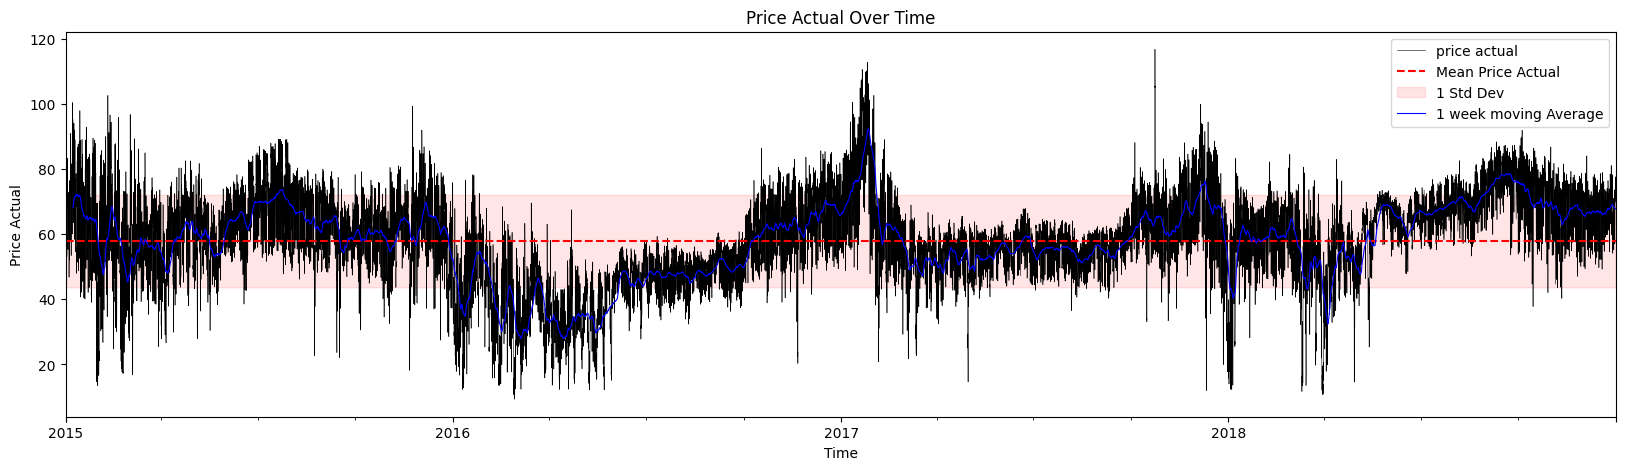

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/ritikdhame/Electricity_Demand_and_Price_forecasting/main/data/energy_dataset.csv"


df_energy = pd.read_csv(url)

# set time to index
df_energy["time"] = pd.to_datetime(df_energy["time"], utc=True)
df_energy = df_energy.set_index("time")


fig, ax = plt.subplots(1, 1, figsize=(20, 5))
df_energy["price actual"].plot(ax=ax, lw=0.4, color="k")
ax.axhline(
    df_energy["price actual"].mean(),
    color="r",
    linestyle="--",
    label="Mean Price Actual",
)
ax.fill_between(
    df_energy.index,
    df_energy["price actual"].mean() - df_energy["price actual"].std(),
    df_energy["price actual"].mean() + df_energy["price actual"].std(),
    color="r",
    alpha=0.1,
    label="1 Std Dev",
)
df_energy["price actual"].rolling(window=24 * 7).mean().plot(
    ax=ax, lw=0.8, color="b", label="1 week moving Average"
)
ax.set(
    title="Price Actual Over Time",
    xlabel="Time",
    ylabel="Price Actual",
    xlim=[df_energy.index.min(), df_energy.index.max()],
)
ax.legend()
fig.savefig("price_actual_over_time.png", dpi=300, bbox_inches="tight")

df_energy.describe().T

In [1]:
# A boat load of imports, just for flexing
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import prophet
import lime
import lime.lime_tabular

from IPython.display import display, HTML
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import (
    Input,
    LSTM,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten,
    Conv1D,
    Bidirectional,
)

In [16]:
# some helper functions


# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):

    print("Number of Nans in each column :")

    print(df_input.isnull().sum())
    print()
    print(f"Number of duplicates in the dataframe : {df_input.duplicated().sum()}")
    return


# Plot the feature correlation matrix
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15, 12))
    # plot heat map
    g = sns.heatmap(corr, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title("Feature Correlation")

    return plt.show()


# Function to transform TS data into a supervised learning format - 
def windowing(X_input, y_input, history_size):

    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])

    return np.array(data), np.array(labels).reshape(-1, 1)

# Reshape to have all features and timesteps ina single row
def reshaping(X):
    reshaped_x = X.reshape(-1, X.shape[1] * X.shape[2])

    # Create column names like 'feature_timestep1', 'feature_timestep2', ...
    feature_names = df_energy.drop(columns=["price actual"]).columns
    columns = [
        f"{feature}_timestep{t+1}"
        for t in range(X.shape[1])
        for feature in feature_names
    ]

    return pd.DataFrame(reshaped_x, columns=columns)

## Data preprocessing


In [ ]:
df_energy = pd.read_csv(url)

# set time to index
df_energy["time"] = pd.to_datetime(df_energy["time"], utc=True)
df_energy = df_energy.set_index("time")
df_energy.index.freq = "h"

# use a subset of rows for speeding up the analysis
df_energy = df_energy.iloc[0:9000, :]

# columns to be removed due to all 0 or Nan values
col_names = [
    "generation fossil coal-derived gas",
    "generation fossil oil shale",
    "generation fossil peat",
    "generation geothermal",
    "generation hydro pumped storage aggregated",
    "generation marine",
    "generation wind offshore",
    "forecast wind offshore eday ahead",
    "forecast solar day ahead",
    "forecast wind onshore day ahead",
]
df_energy = df_energy.drop(col_names, axis=1, errors="ignore")

# interpolate missing values
df_energy.interpolate(method="linear", limit_direction="forward", inplace=True)

# combine two features:
df_energy["generation fossil total"] = (
    df_energy["generation fossil hard coal"]
    + df_energy["generation fossil brown coal/lignite"]
)
df_energy.drop(
    ["generation fossil hard coal", "generation fossil brown coal/lignite"],
    axis=1,
    inplace=True,
)
# drop the forecast column
df_energy.drop(["total load forecast"], axis=1, inplace=True)

## Trend / Seasonality decomposition


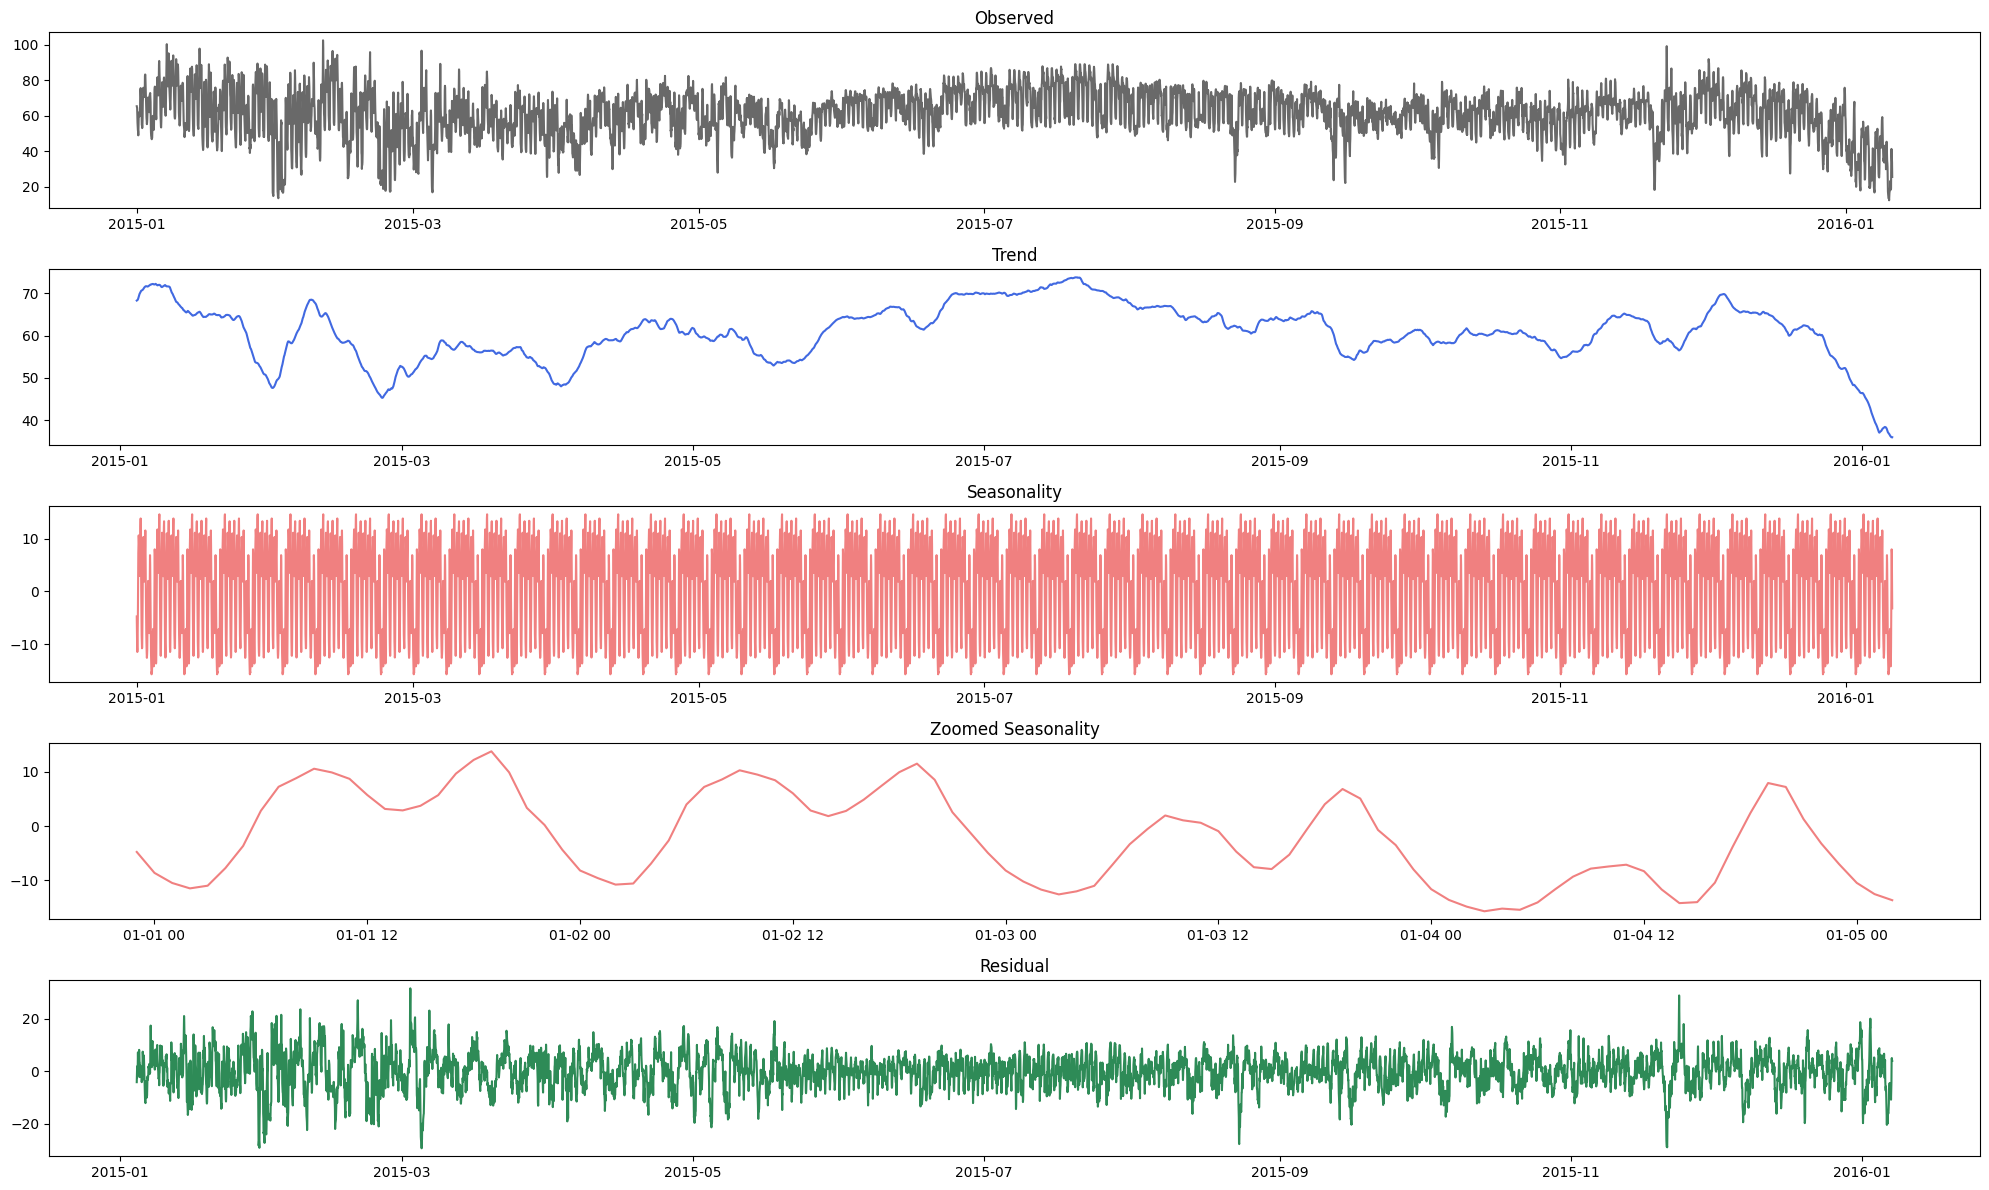

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_energy[["price actual"]].copy()

# seasonal decompose with a weekly period (24 hours * 7 days)
decompose_result = seasonal_decompose(decom_data, period=24 * 7, model="additive")

observed = decompose_result.observed
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color="dimgrey")
axes[0].set_title("Observed")
axes[1].plot(trend, color="royalblue")
axes[1].set_title("Trend")
axes[2].plot(seasonal, color="lightcoral")
axes[2].set_title("Seasonality")
axes[3].plot(seasonal[:100], color="lightcoral")
axes[3].set_title("Zoomed Seasonality")
axes[4].plot(residual, color="seagreen")
axes[4].set_title("Residual")

fig.tight_layout()
plt.show()

## Train-test split


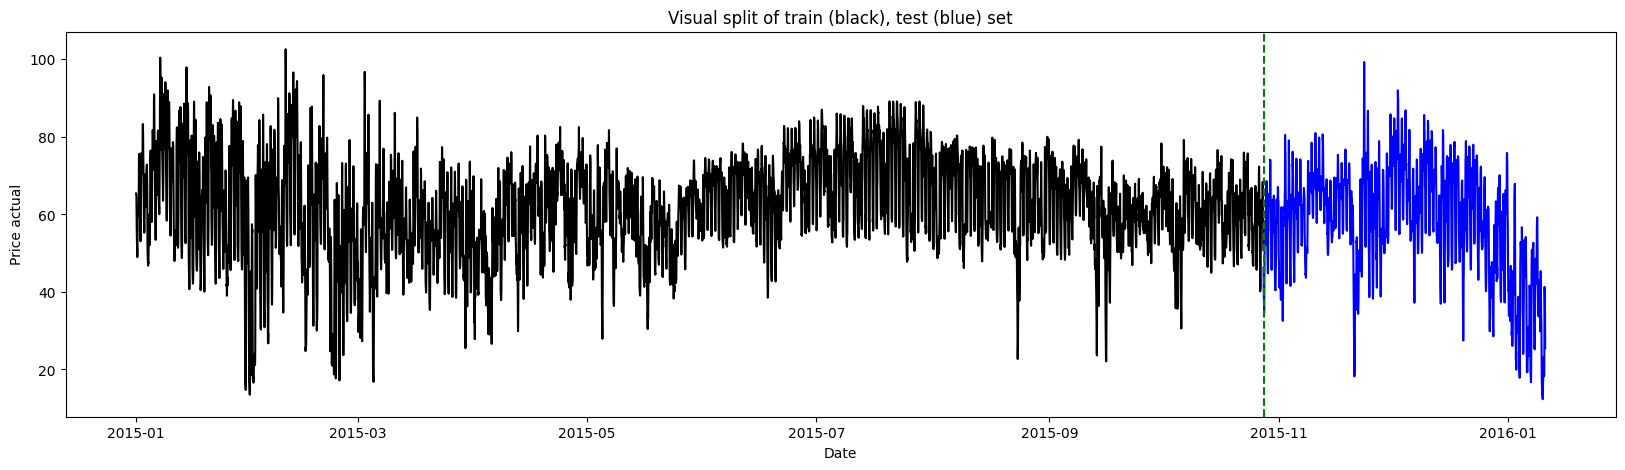

In [20]:
def get_train_test(hist_size=24):
    """
    hist_size: int, size of the history window
    """

    X = df_energy.drop(["price actual"], axis=1)
    y = df_energy[["price actual"]]

    # training set size

    train_cutoff = int(len(X) * 0.8)

    # scale the data

    scaler_y = MinMaxScaler()
    scaler_y.fit(y[:train_cutoff])
    y_norm = scaler_y.transform(y)

    scaler_X = MinMaxScaler()
    scaler_X.fit(X[:train_cutoff])
    X_norm = scaler_X.transform(X)

    # create the windowed data

    data_norm = np.concatenate((X_norm, y_norm), axis=1)
    X_train, y_train = windowing(
        data_norm[:train_cutoff, :-1], data_norm[:train_cutoff, -1], hist_size
    )

    X_test, y_test = windowing(
        data_norm[train_cutoff:, :-1], data_norm[train_cutoff:, -1], hist_size
    )
    return X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X


X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test()


fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(df_energy["price actual"].iloc[:train_cutoff], color="black")
axes.plot(df_energy["price actual"].iloc[train_cutoff:], color="blue")
axes.axvline(x=df_energy.index[train_cutoff], color="green", linestyle="--")
axes.set_title("Visual split of train (black), test (blue) set")
axes.set_xlabel("Date")
axes.set_ylabel("Price actual")
plt.show()

## Seasonal Decomposition forecast

- Univariate forecast
- Trend is extrapolated


Text(0.5, 1.0, 'MAE of the forecast: 3.06')

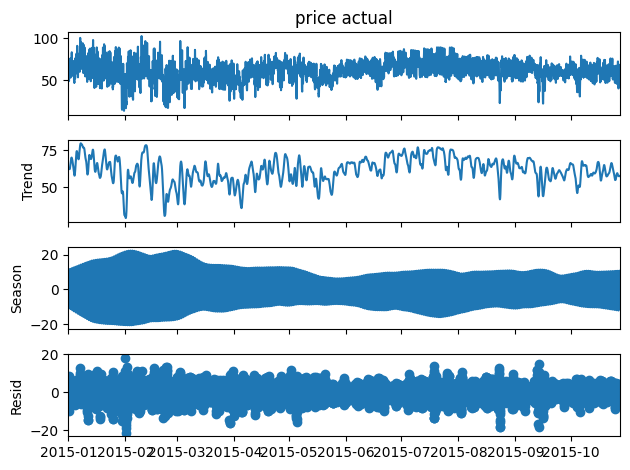

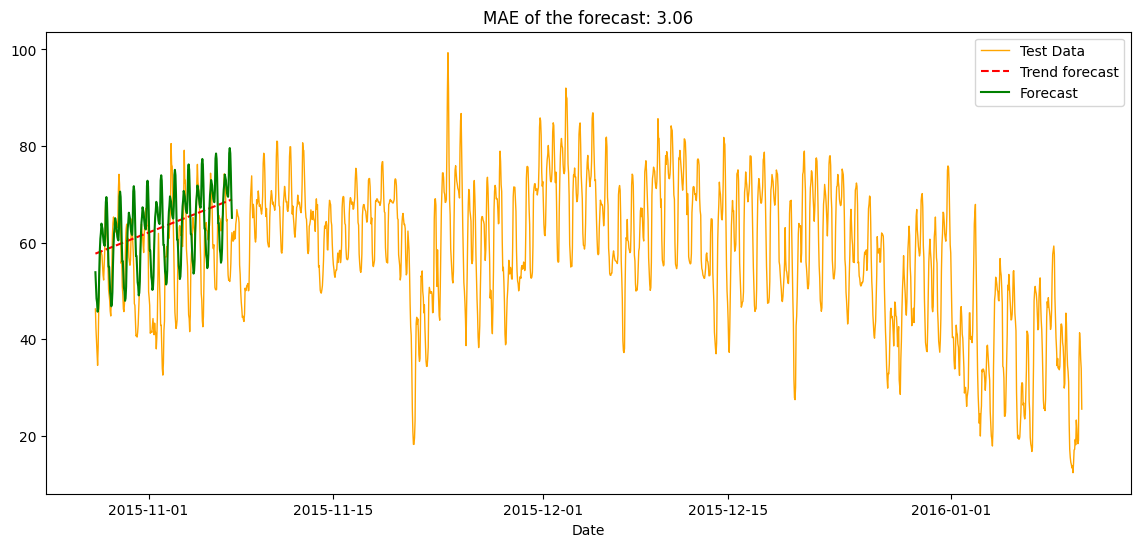

In [21]:

df_energy.index.freq = "h"
y_train = df_energy["price actual"].iloc[:train_cutoff]
y_test = df_energy["price actual"].iloc[train_cutoff:]


# Apply STL decomposition
seasonality = 25
stl = STL(y_train, seasonal=seasonality)
result = stl.fit()

# Plot the decomposition
result.plot()


# Forecast the trend using Holt's linear trend method
trend_model = ExponentialSmoothing(result.trend.dropna(), trend="add", seasonal=None)
trend_fit = trend_model.fit()

# number of seasons to forecast
n_seasons = 10

# forecast the trend component
trend_forecast = trend_fit.forecast(n_seasons * seasonality)

# Repeat the last seasonal cycle
seasonal_forecast = np.tile(result.seasonal[-seasonality:].values, n_seasons)

# Combine trend and seasonal forecasts
forecast = trend_forecast + seasonal_forecast

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# uncomment to plot also the training part
# -------------
# ax.plot(result.trend, c="r", label="Trend Component")
# ax.plot(result.seasonal + result.trend, color="b", label="Trend + Seasonal")
# ax.plot(y_train, label="Train data", c="k", lw=1)
# -------------
ax.plot(y_test, label="Test Data", c="orange", lw=1)
ax.plot(trend_forecast, label="Trend forecast", color="r", linestyle="--")
ax.plot(trend_forecast.index, forecast, label="Forecast", color="green")
ax.set_xlabel("Date")
ax.legend()

rmse = np.sqrt(mean_absolute_error(y_test[: seasonality * n_seasons], forecast))
ax.set_title(f"MAE of the forecast: {rmse:.2f}")

### SARIMA forecast

- Univariate
- Optimize order parameters


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-22786.386, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-25024.144, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-24772.264, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-22788.385, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-24904.631, Time=0.43 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=-25062.163, Time=1.71 sec
 ARIMA(1,1,0)(3,0,0)[4] intercept   : AIC=-25151.667, Time=2.26 sec
 ARIMA(1,1,0)(3,0,1)[4] intercept   : AIC=-25132.433, Time=2.61 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=-25088.624, Time=2.02 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=-23718.419, Time=2.46 sec
 ARIMA(2,1,0)(3,0,0)[4] intercept   : AIC=-25146.846, Time=2.56 sec
 ARIMA(1,1,1)(3,0,0)[4] intercept   : AIC=-25151.816, Time=2.19 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=-25082.900, Time=1.84 sec
 ARIMA(1,1,1)(3,0,1)[4] intercept   : AIC=-25125.826, Time=2.22 sec
 ARIM

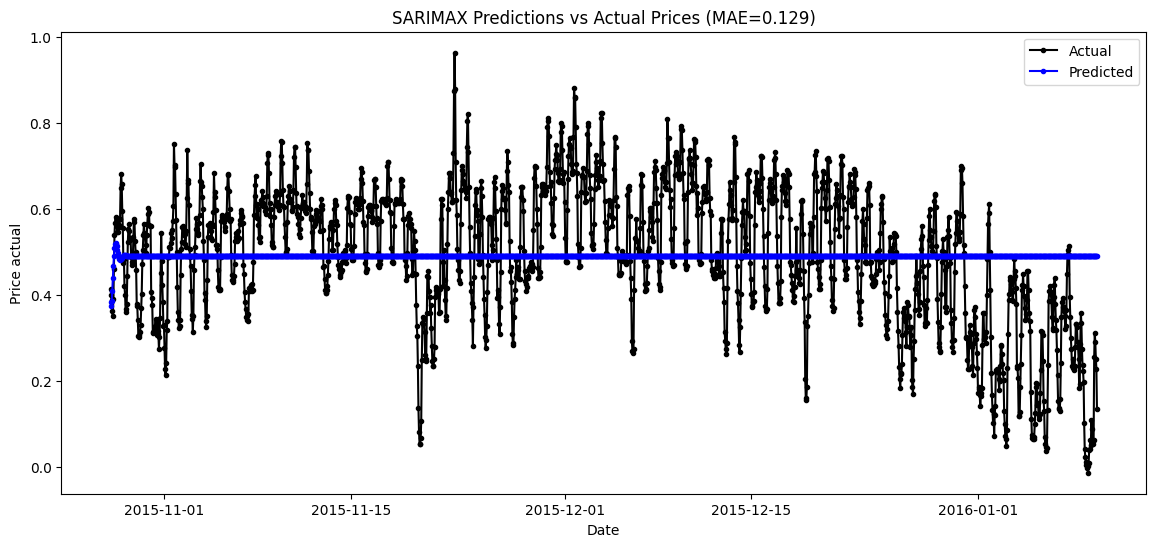

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# history size (number of hours)
hist_size = 24

# Generate training & test datasets
X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test(hist_size=hist_size)

X_train_arima = reshaping(X_train)
X_test_arima = reshaping(X_test)


# Fit AutoARIMA model (with exogenous variables)
autoarima_model = auto_arima(
        y_train,
        # X=X_train_arima, # with extra features this takes a loooong time
        start_p=0,
        start_q=0,
        max_p=3,
        max_d=3,
        max_q=3,
        seasonal=True,
        start_P=0,
        start_Q=0,
        max_P=3,
        max_D=3,
        max_Q=3,
        m=4,
        d=None,
        D=None,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
        n_jobs=-1,
        method="nm",
        maxiter=100
)
#TODO : Try out different values for m (seasonality) -- can influence comp. cost
#TODO : Perform feature engineering, e.g. rolling means
#TODO : Try out different history sizes

# Forecast
y_pred = autoarima_model.predict(n_periods=len(y_test))

# Inverse transform the predictions and actual values
y_pred_actual = y_pred.reshape(-1, 1)
y_test_inv = y_test.reshape(-1, 1)

# Calculate MAE
mae = mean_absolute_error(y_pred_actual, y_test_inv)

# Plot the results
fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(
    df_energy["price actual"].iloc[train_cutoff:].index[:len(y_test_inv)],
    y_test_inv,
    "k.-",
    label="Actual",
)
axes.plot(
    df_energy["price actual"].iloc[train_cutoff:].index[:len(y_pred_actual)],
    y_pred_actual,
    "b.-",
    label="Predicted",
)
axes.set(xlabel="Date", ylabel="Price actual")
axes.set_title(f"SARIMAX Predictions vs Actual Prices (MAE={mae:.3f})")
axes.legend()
plt.show()

### XGBOOST forecast

- Multivariate
- Supervised learning problem
- Can be extended with more feature engineering


Text(0.5, 1.0, 'XGBoost Predictions vs Actual Prices (MAE=7.076)')

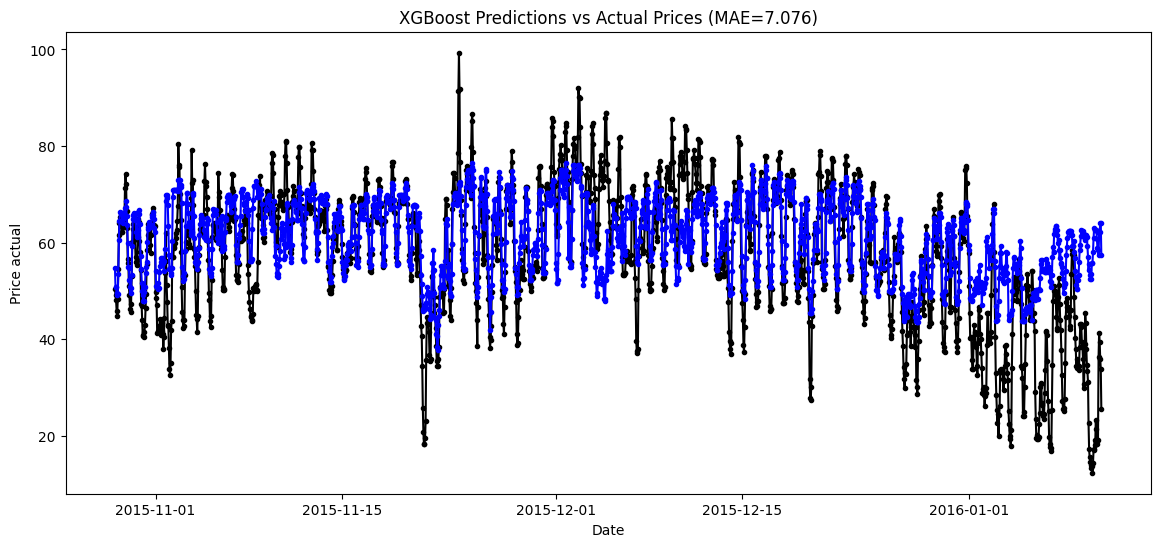

In [ ]:
# number of hours to look back
hist_size = 24

X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test(
    hist_size=hist_size
)

#TODO : Perform feature engineering, e.g. rolling means
#TODO : Perform feature selection and combine with e.g. PCA
#TODO : Try out different history sizes

X_train_xgb = reshaping(X_train)
X_test_xgb = reshaping(X_test)

# Grid of parameters to choose from
xgb_params = {
    "n_estimators": [10, 50, 100],
    "subsample": [0.6, 0.8, 1],
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "gamma": [0.01, 0.1, 1, 5],
    "alpha": [0, 0.1, 0.5],
}


xgb_model = xgb.XGBRegressor()


# Uncomment the following lines to perform grid search
# ---------------------------------------------------
# grid_xgb = GridSearchCV(
#     xgb_model,
#     xgb_params,
#     cv=3,
#     n_jobs=-1,
#     verbose=10,
# )


# grid_xgb.fit(X_train_xgb, y_train)
# xgb_best_model = grid_xgb.best_estimator_

# print("Best parameters found: ", grid_xgb.best_params_)

# y_pred = xgb_best_model.predict(X_test_xgb)

# mae = mean_absolute_error(y_pred, y_test)
# print(f"Mean Absolute Error: {round(mae,3)}")
# ---------------------------------------------------

# Fit the model
xgb_model = xgb.XGBRegressor(
    **{
        "alpha": 0.1,
        "gamma": 1,
        "learning_rate": 0.1,
        "n_estimators": 50,
        "subsample": 0.8,
    }
)
xgb_model.fit(
    X_train_xgb,
    y_train,
    eval_set=[(X_train_xgb, y_train)],
    verbose=False,
)

y_pred = xgb_model.predict(X_test_xgb)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)
mae = mean_absolute_error(y_pred_actual, y_test_inv)


fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(
    df_energy["price actual"].iloc[train_cutoff + hist_size :].index,
    y_test_inv,
    "k.-",
    label="Actual",
)
axes.plot(
    df_energy["price actual"].iloc[train_cutoff + hist_size :].index,
    y_pred_actual,
    "b.-",
    label="Predicted",
)
axes.set(xlabel="Date", ylabel="Price actual")
axes.set_title(f"XGBoost Predictions vs Actual Prices (MAE={mae:.3f})")

### XGBoost global + local explanation with SHAP


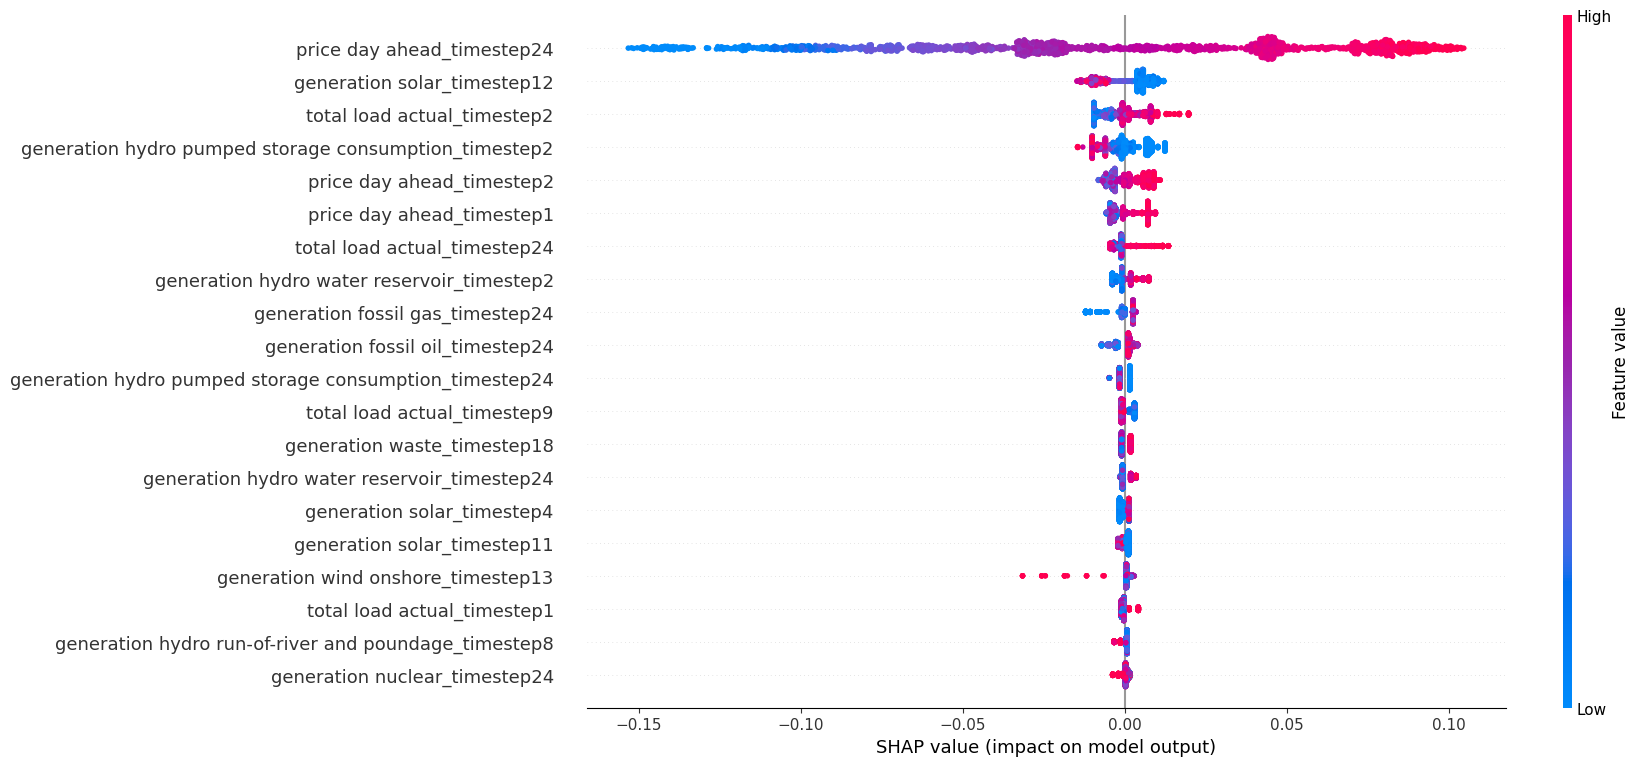

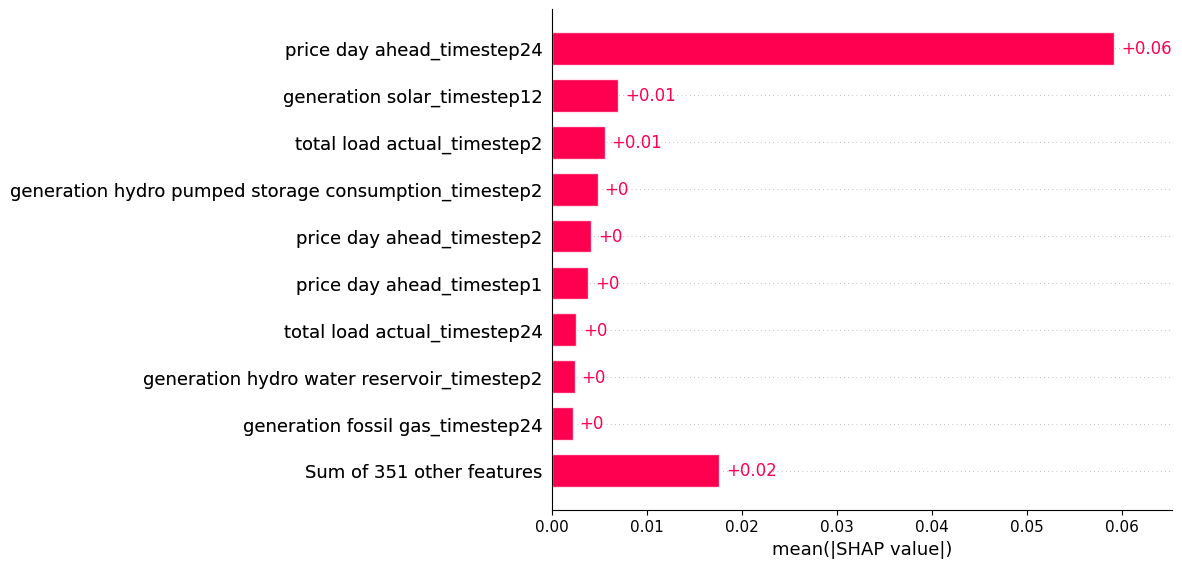

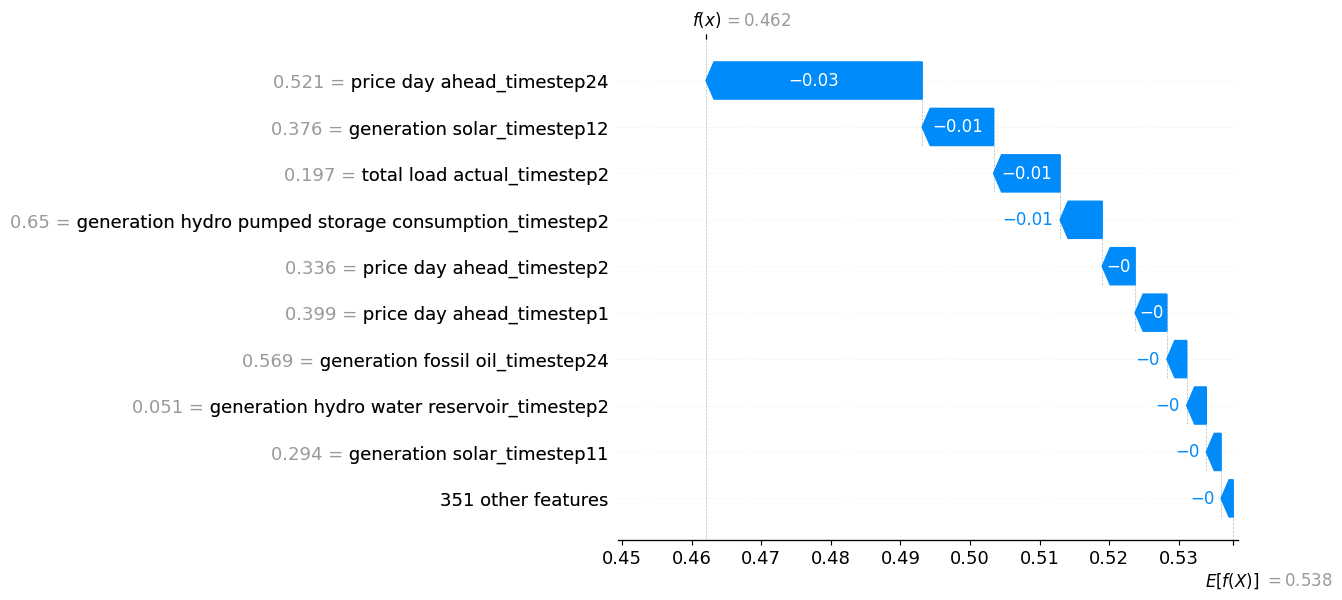

In [39]:
# SHAP expplantions

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_xgb)

# Summary plot: global feature importance
shap.summary_plot(shap_values, X_test_xgb, show=False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(5 * h, 0.8 * h)
plt.show()

# Bar plot: mean absolute SHAP values
shap.plots.bar(shap_values)

# Waterfall plot: local feature importance for the first prediction
shap.waterfall_plot(shap_values[0])

### XGBoost local explanation with LIME


In [40]:

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_xgb),
    feature_names=X_train_xgb.columns.tolist(),
    mode="regression",
)

# Select a few samples from the test set for explanation
samples_to_explain = X_test_xgb.iloc[:1, :]

# Generate and display LIME explanations
for i, (index, sample) in enumerate(samples_to_explain.iterrows()):
    explanation = lime_explainer.explain_instance(
        data_row=sample.values,
        predict_fn=xgb_model.predict,
        num_features=len(X_train_xgb.columns),
    )
    display(HTML(explanation.as_html()))

### LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0172
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0099
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0082
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0071
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0067
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0056
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0054
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048
Epoch 13/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0046
Epoch 14/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045
Epoch 15/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

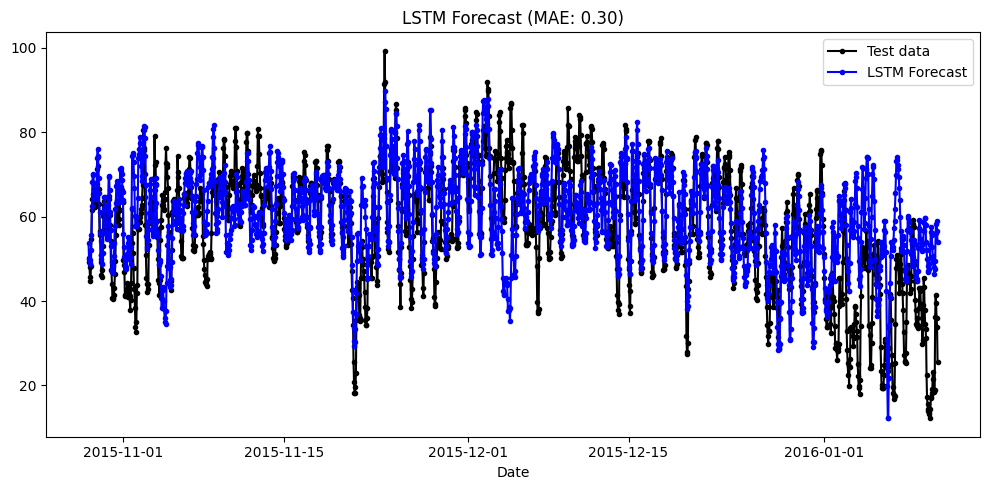

In [ ]:
hist_size = 24

X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test(
    hist_size=hist_size
)


n_features = X_train.shape[2]  # Number of features in the input


# Build LSTM model
model = Sequential()
model.add(Input(shape=(hist_size, n_features)))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()
#TODO : Try out different architectures, like Conv1D, Bidirectional LSTM, etc.
#TODO : Try out different history sizes

# fit the model
model.fit(X_train, y_train, epochs=50)


y_pred = model.predict(X_test)


# Plot results
fig, ax = plt.subplots(figsize=(10, 5))


ax.plot(
    df_energy.iloc[train_cutoff + hist_size :].index,
    scaler_y.inverse_transform(y_test),
    "k.-",
    label="Test data",
)
ax.plot(
    df_energy.iloc[train_cutoff + hist_size :].index,
    scaler_y.inverse_transform(y_pred),
    "b.-",
    label="LSTM Forecast",
)
ax.set_title(f"LSTM Forecast (MAE: {np.sqrt(mean_absolute_error(y_test, y_pred)):.2f})")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

### Saliency map of the LSTM


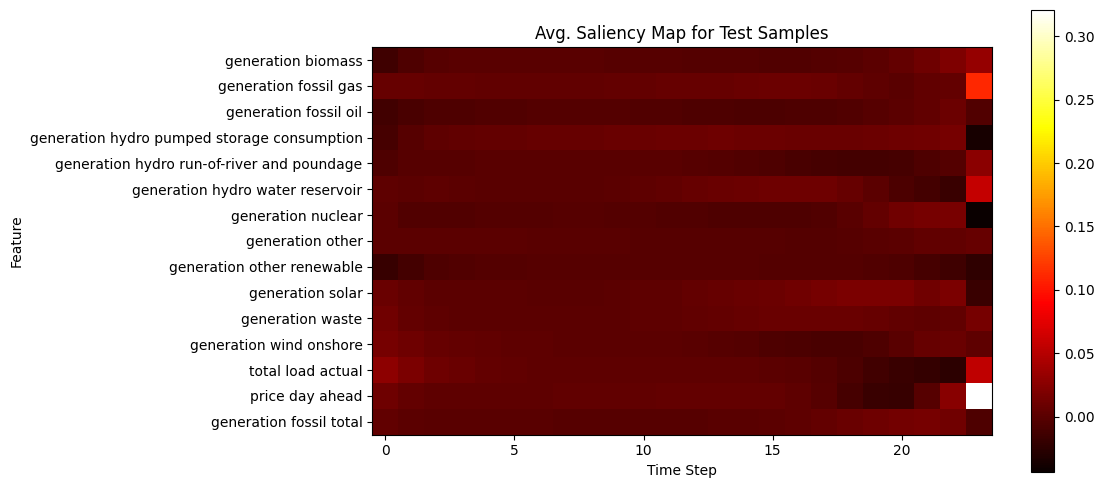

In [42]:
# %% based on gradients, calculate how much each feature contributes to the prediction


# X_test is your test input of shape (samples, timesteps, features)
# model is your trained LSTM model
def compute_saliency_maps(model, X):
    """
    Compute saliency map for each sample in X
    """
    X_var = tf.Variable(X, dtype=float)
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        predictions = model(X_var)
    gradients = tape.gradient(predictions, X_var)
    return gradients.numpy()


# Compute saliency maps
saliency_maps = compute_saliency_maps(model, X_test)

# Plot saliency map for the first test sample
feature_names = df_energy.drop(columns=["price actual"]).columns
plt.figure(figsize=(10, 6))
plt.title("Avg. Saliency Map for Test Samples")
plt.xlabel("Time Step")
plt.ylabel("Feature")
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.imshow(np.mean(saliency_maps, axis=0).T, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.show()

### ShapTime: see important time steps in training


In [43]:
from ShapTime import ShapleyValues, TimeImportance, TimeHeatmap


Tn = 10  # number of time steps
shap_values = ShapleyValues(model, X_train, Tn)
time_columns = [f"Time Step {i+1}" for i in range(Tn)]
shap_values = np.array(shap_values)

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━

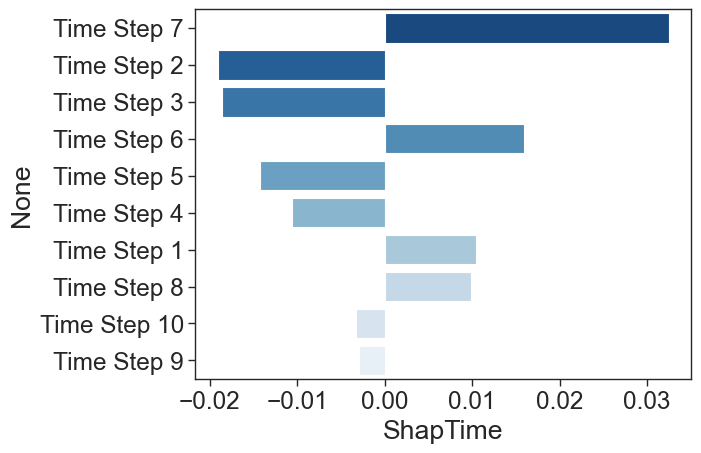

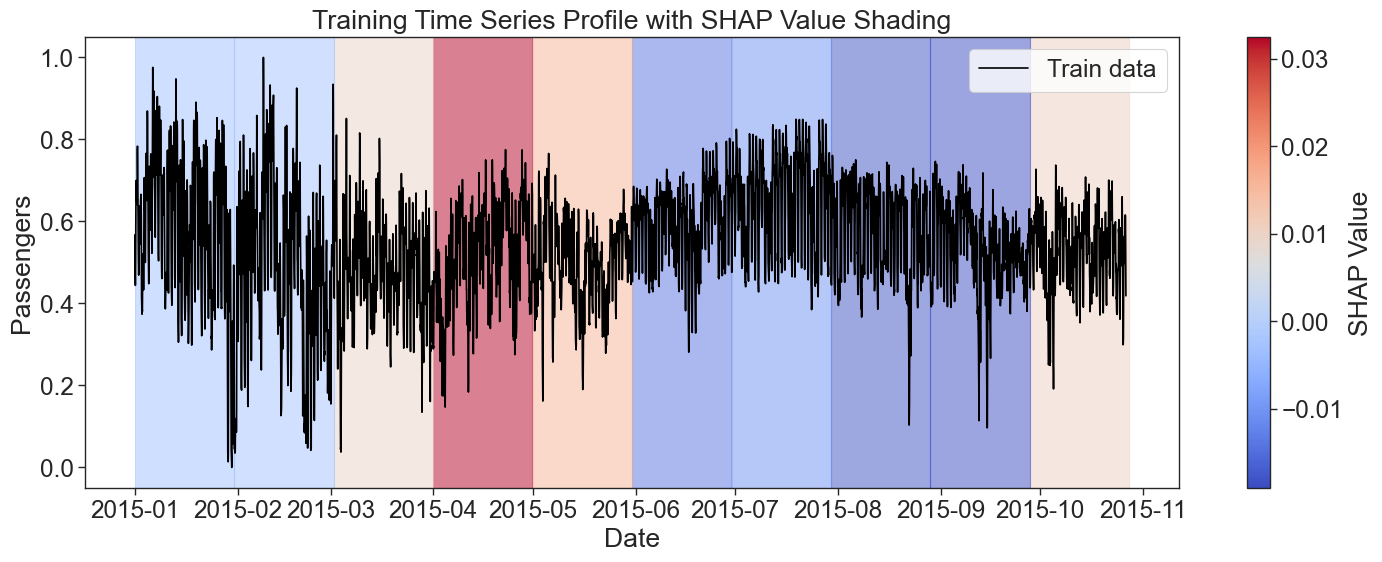

In [44]:
TimeImportance(Tn, shap_values, time_columns)
# ax = TimeHeatmap(Tn, shap_values, time_columns)


# Normalize SHAP values for color mapping
norm = plt.Normalize(shap_values.min(), shap_values.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(
    df_energy[: train_cutoff - hist_size].index, y_train, label="Train data", c="black"
)

# Shade time steps, adjusting x-axis spans to reflect 1/10th of the total timeframe
total_timeframe = len(df_energy[:train_cutoff].index)
time_step_span = total_timeframe // len(shap_values)

for i in range(len(shap_values)):
    start_idx = (len(shap_values) - 1 - i) * time_step_span
    end_idx = (len(shap_values) - i) * time_step_span
    ax.axvspan(
        df_energy[:train_cutoff].index[start_idx],
        df_energy[:train_cutoff].index[end_idx - 1],
        color=sm.to_rgba(shap_values[i]),
        alpha=0.5,
    )

ax.set_title("Training Time Series Profile with SHAP Value Shading")
ax.set_xlabel("Date")
ax.set_ylabel("Passengers")
ax.legend()
plt.colorbar(sm, ax=ax, label="SHAP Value")
plt.tight_layout()
plt.show()

## Prophet forecasts


16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:10 - cmdstanpy - INFO - Chain [1] done processing


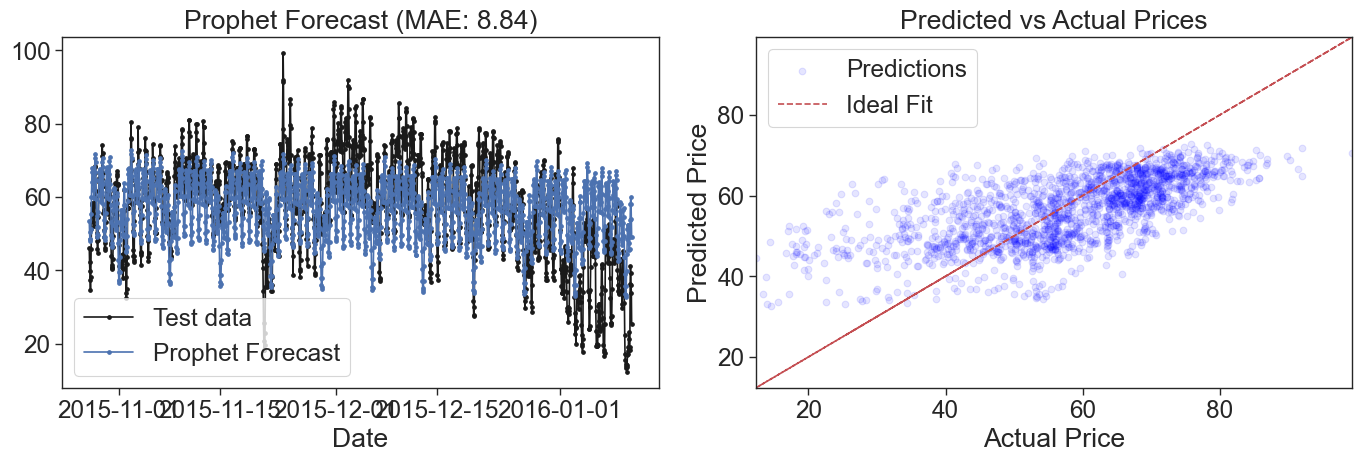

                           generation biomass  generation fossil gas  \
time                                                                   
2014-12-31 23:00:00+00:00               447.0                 4844.0   
2015-01-01 00:00:00+00:00               449.0                 5196.0   
2015-01-01 01:00:00+00:00               448.0                 4857.0   
2015-01-01 02:00:00+00:00               438.0                 4314.0   
2015-01-01 03:00:00+00:00               428.0                 4130.0   
...                                       ...                    ...   
2015-10-27 18:00:00+00:00               524.0                 5322.0   
2015-10-27 19:00:00+00:00               525.0                 5030.0   
2015-10-27 20:00:00+00:00               530.0                 4855.0   
2015-10-27 21:00:00+00:00               524.0                 4536.0   
2015-10-27 22:00:00+00:00               502.0                 4157.0   

                           generation fossil oil  \
time       

In [ ]:
# Prepare training data
df_train = df_energy.iloc[:train_cutoff].copy()
df_train = df_train.rename(columns={"price actual": "y"})  # Prophet requires 'y'
df_train["ds"] = df_train.index.to_series().dt.tz_localize(None)  # Prophet requires 'ds' without timezone

# Initialize and fit the Prophet model
prophet_model = prophet.Prophet()
#TODO : Add any additional Prophet parameters if needed
#TODO : Add extra regressors if needed
prophet_model.fit(df_train)

# Create future dataframe for prediction
df_future = df_energy.iloc[train_cutoff:].copy()
df_future["ds"] = df_future.index.to_series().dt.tz_localize(None)  # Prophet requires 'ds' without timezone

# Make forecasts
df_forecast = prophet_model.predict(df_future)

# Extract predicted values
y_pred = df_forecast["yhat"].values.reshape(-1, 1)

# test set data
y_test = df_energy["price actual"].iloc[train_cutoff:].values.reshape(-1, 1)

# Compute MAE
mae = mean_absolute_error(y_test, y_pred)

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Time series plot
axes[0].plot(
    df_energy.iloc[train_cutoff:].index,
    y_test,
    "k.-",
    label="Test data",
)
axes[0].plot(
    df_energy.iloc[train_cutoff:].index,
    y_pred,
    "b.-",
    label="Prophet Forecast",
)
axes[0].set_title(f"Prophet Forecast (MAE: {mae:.2f})")
axes[0].set_xlabel("Date")
axes[0].legend()

# Scatter plot: Predictions vs Actual Values
axes[1].scatter(y_test, y_pred, alpha=0.1, color="blue", label="Predictions")
axes[1].plot(y_test, y_test, "r--", label="Ideal Fit")  # Diagonal line (y=x)
axes[1].set_title("Predicted vs Actual Prices")
axes[1].set_xlabel("Actual Price")
axes[1].set_ylabel("Predicted Price")
axes[1].set_xlim([y_test.min(), y_test.max()])
axes[1].set_ylim([y_test.min(), y_test.max()])
axes[1].legend()

plt.tight_layout()
plt.show()
